### 이 코드는 연구의 전반부 목적인 논문 재현까지의 흐름을 담고 있습니다. 
### 해당 코드의 결과를 통해 ddpm을 활용한 data augmentation의 Inverse Ising Inference 에서의 추론 성능 향상을 확인하였습니다.

In [1]:
# 필요한 라이브러리 임포트
import os
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import math
import itertools
import scipy as sp
from time import perf_counter
from functools import partial
import multiprocessing
from numba import jit
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# 사용하고자 하는 ddpm 스케줄링을 미리 정의합니다.

def f(t, T, s=0.008):
    return torch.cos(((t / T) + s) / (1 + s) * torch.pi / 2) ** 2
def beta_schedule(beta1, beta2, T, schedule='cosine'):
    if schedule == 'linear':
        # Linear schedule: linearly increase beta from beta1 to beta2
        betas = torch.linspace(beta1, beta2, T)

    elif schedule == 'cosine':
        # Cosine schedule
        s = 0.008
        timesteps = torch.arange(0, T + 1)  # t from 0 to T
        f_t = f(timesteps, T, s)  # f(t) for t=0 to T
        
        bar_alpha = f_t / f_t[0]
        
        # Initialize betas tensor
        betas = torch.zeros(T)
        
        # Compute betas using the given formula
        for t in range(1, T + 1):
            beta = 1 - (bar_alpha[t] / bar_alpha[t - 1])
            beta = torch.clamp(beta, min=0.0, max=0.999)
            betas[t - 1] = beta
    
    else:
        raise ValueError("Schedule must be either 'linear' or 'cosine'.")
    
    return betas

def ddpm_schedules(beta1, beta2, T, schedule='cosine'):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert 0 < beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"
    
    beta_t = beta_schedule(beta1, beta2, T, schedule)
    
    sqrt_beta_t = torch.sqrt(beta_t)                    # \sqrt{\beta_t}
    alpha_t = 1 - beta_t                                 # \alpha_t
    alphabar_t = torch.cumprod(alpha_t, dim=0)           # \bar{\alpha_t}
    sqrtab = torch.sqrt(alphabar_t)                      # \sqrt{\bar{\alpha_t}}
    oneover_sqrta = 1 / torch.sqrt(alpha_t)              # 1/\sqrt{\alpha_t}
    sqrtmab = torch.sqrt(1 - alphabar_t)                 # \sqrt{1 - \bar{\alpha_t}}
    bt_over_sqrtmab = beta_t / sqrtmab                   # \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}}
    
    return {
        "beta_t": beta_t,                          # \beta_t
        "sqrt_beta_t": sqrt_beta_t,                # \sqrt{\beta_t}
        "alpha_t": alpha_t,                        # \alpha_t
        "alphabar_t": alphabar_t,                  # \bar{\alpha_t}
        "sqrtab": sqrtab,                          # \sqrt{\bar{\alpha_t}}
        "oneover_sqrta": oneover_sqrta,            # 1/\sqrt{\alpha_t}
        "sqrtmab": sqrtmab,                        # \sqrt{1 - \bar{\alpha_t}}
        "bt_over_sqrtmab": bt_over_sqrtmab,        # \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}}
    }

In [3]:
# Ising 모델의 샘플을 생성하여 ddpm의 data augmentation 결과와 비교할 기본 데이터셋을 만들기 위해, MCMC 알고리즘을 정의합니다.

# Metropolis Algorithm

# decide whether to flip a chosen spin or not
@jit(nopython=True,cache=True)
def Metro(seq,i,h,J):
    # seq: (sigma_1, sigma_2, ..., sigma_N), sigma = 1 or -1
    # i: chosen spin
    
    dE = 2*seq[i]*(h[i]+np.dot(J[i,:],seq))
    if dE<0:
        seq[i] = -seq[i]
    else:
        prob = np.exp(-dE)
        if np.random.rand() < prob:
            seq[i] = -seq[i]
    return seq

# Markov chain Monte Carlo
def MCMC_nonparallel(seed,L,N,h,J):
    # we do not use "seed" here
    # L: sample size, N: system size, h & J: Ising parameters
    
    seq = np.random.choice(np.array([+1.0,-1.0]),N) # initial random sequence
    
    iset = np.arange(N)
    
    # thermalizing step
    @jit(nopython=True)
    def thermalize(seq):
        nstep = N*10000 # run N*5000 Metropolis steps
        for step in range(nstep):
            i = np.random.choice(iset)
            seq = Metro(seq,i,h,J)
        return seq
    
    seq = thermalize(seq)
    
    # sampling step
    @jit(nopython=True)
    def sampling(seq):
        s = np.zeros((L,N)) # sampling data
        interval = N*100 # sample a sequence per each N*50 steps
        nstep = interval*(L-1)+1
        ind = 0
        for step in range(nstep):
            i = np.random.choice(iset)
            seq = Metro(seq,i,h,J)
            if step%interval==0:
                s[ind,:] = seq
                ind += 1
        return s
    
    s = sampling(seq)
    
    return s

# Markov chain Monte Carlo with parallel computing
def MCMC(L,N,h,J,n_par=1):
    # n_par: number of parallel cores
    
    n_par = int(n_par)
    
    if n_par==1: # no parallel computing
        return MCMC_nonparallel(L=L,N=N,h=h,J=J,seed=0)
    
    else: # run parallel computing
        pool = multiprocessing.Pool(processes=n_par)
        MCMC_individual = partial(MCMC_nonparallel,L=int(L/n_par)+1,N=N,h=h,J=J)
        s_list = pool.map(MCMC_individual,range(n_par))
        pool.close()
        return np.concatenate(s_list,axis=0)[:L,:]
    
@jit(nopython=True,cache=True)
def statistics(s):
    # return <sigma_i> and <sigma_i * sigma_j>
    
    L, N = s.shape # L: sample size, N: system size
    
    m = np.sum(s,axis=0)/L # mean activity
    m2 = s.T@s/L # <sigma_i * sigma_j>
    
    for i in range(N):
        m2[i,i] = 0
    
    return m, m2


In [4]:
# operator로 연산하기 위해 함수를 정의합니다.

# convert s[n_seq,n_var] to ops[n_seq,n_ops]
def operators(s):
    #generate terms in the energy function
    n_seq,n_var = s.shape
    ops = np.zeros((n_seq,n_var+int(n_var*(n_var-1)/2.0)))

    jindex = 0
    for index in range(n_var):
        ops[:,jindex] = s[:,index]
        jindex +=1

    for index in range(n_var-1):
        for index1 in range(index+1,n_var):
            ops[:,jindex] = s[:,index]*s[:,index1]
            jindex +=1

    return ops

def energy_ops(ops,J):
    return np.sum(ops*J[np.newaxis,:],axis=1)

In [5]:
# Inverse Ising Inference를 위해 erasure machine을 방법론으로 채택하고 이를 구현합니다. 
# erasure machine

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_energy(seq, h, J):
    field_term = -np.dot(h, seq)
    interaction_term = -np.sum(np.triu(J, k=1) * np.outer(seq, seq))
    return field_term + interaction_term

def estimate_f_epsilon(samples, h, J, epsilon):
    energies = np.array([compute_energy(s, h, J) for s in samples])
    ps = np.exp(-energies)
    ps_epsilon = ps ** (-1 + epsilon)
    weights = ps_epsilon / np.sum(ps_epsilon)
    return weights

def update_parameters(samples, h, J, epsilon, lr):
    n = samples.shape[1]
    weights = estimate_f_epsilon(samples, h, J, epsilon)

    mean_sigma = np.zeros(n)
    for s, wgt in zip(samples, weights):
        mean_sigma += wgt * s
    #mean_sigma = np.average(samples, axis=0, weights=weights)  # ⟨σ_i⟩_{f_ε}
    mean_sigma_sigma = np.zeros((n, n))
    for s, wgt in zip(samples, weights):
        #mean_sigma_sigma += wgt * np.einsum("i,j->ij", s, s)
        mean_sigma_sigma += wgt * np.outer(s, s)
    np.fill_diagonal(mean_sigma_sigma, 0)
    h_model = epsilon * h
    J_model = epsilon * J

    #print(np.linalg.norm(mean_sigma - h_model))
    
    h_new = h + lr * (mean_sigma - h_model)
    J_new = J + lr * (mean_sigma_sigma - J_model)
    
    return h_new, J_new

def train_erasure_machine(samples, n, epsilon=0.05, lr=0.1, epochs=100):
    h_temp = np.random.randn(n) * 0.01
    J_temp = np.random.randn(n, n) * 0.01
    J_temp = (J_temp + J_temp.T) / 2  # Make symmetric
    np.fill_diagonal(J_temp, 0)

    for epoch in range(epochs):
        h_temp, J_temp = update_parameters(samples, h_temp, J_temp, epsilon, lr)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: h norm = {np.linalg.norm(h_temp):.4f}, J norm = {np.linalg.norm(J_temp):.4f}")
    return h_temp, J_temp

# erasure machine을 테스트해본 결과, 
# s=[샘플수, 모델 차원], L은 모델 차원(40), 엡실론은 0.7 정도일 때 결과가 가장 잘 나왔고 에폭도 150 정도에서 잘 수렴하는 것을 확인해,
# 에폭 150, 엡실론 0.7을 이후 연구에서도 활용하고자 했습니다.

Shape of s_tensor: torch.Size([5000, 40])
Mean Energy: 0.1416
Std Energy: 4.5189
Min Energy: -15.9554
Max Energy: 18.4510


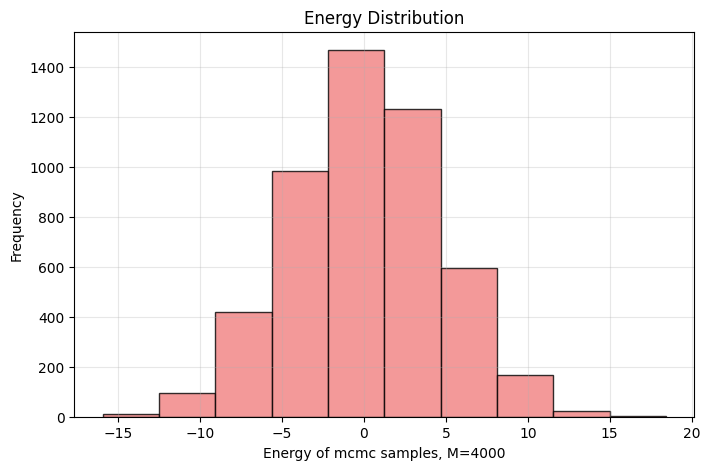

In [8]:
# data augmentation의 III 효과를 보기 위한 실험 설계의 구체적 과정입니다. 
# 먼저 MCMC로 Ising 모델의 샘플을 생성하고, 이를 DDPM 모델 학습에 활용할 수 있는 형태로 변환합니다.
# 그리고 DDPM 모델을 학습시켜 MCMC 샘플만으로 III를 진행했을 때의 성능과,
# DDPM 모델이 생성한 샘플을 augmentation에 활용했을 때의 성능을 MSE와 Var[E] 그래프로 비교합니다.

# 1. MCMC 샘플 생성
N = 40  # 시스템 크기
L = 4000  # 샘플 개수

# generate samples
g_h = 0.2 # scale for h
g_J = 1.0 # scale for J

h_true = np.random.normal(0.0,g_h,N) # external bias
J_true = np.random.normal(0.0,g_J/np.sqrt(N),(N,N)) # coupling

np.save("ising_h_real.npy", h_true)
np.save("ising_J_real.npy", J_true)

# symmetrize the coupling
for i in range(N):
    J_true[i,i] = 0
    
for i in range(N-1):
    for j in range(i+1,N):
        J_true[i,j] = J_true[j,i]
    

# 기존 MCMC 함수 사용
s = np.load("ising_samples.npy")

# PyTorch Tensor 변환
s_tensor = torch.from_numpy(s).float()  # (L, N) 크기
print(f"Shape of s_tensor: {s_tensor.shape}")  # (5000, 40)

# DataLoader 생성
batch_size = 256
dataset = TensorDataset(s_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# mcmc의 에너지 분포를 시각화하기 위한 함수
def plot_energy_distribution(s_tensor, h, J, bins=10, title="Energy Distribution"):
    """
    s_tensor: (L, N) torch tensor
    h_true: (N,) numpy array
    J_true: (N, N) numpy array
    """
    # h, J를 Torch Tensor로 변환
    h_torch = torch.from_numpy(h_true).float().to(s_tensor.device)
    J_torch = torch.from_numpy(J_true).float().to(s_tensor.device)

    # 에너지 계산
    E_h = -torch.matmul(s_tensor, h_torch)  # (L,)
    E_J = -torch.einsum('bi,ij,bj->b', s_tensor, J_torch, s_tensor) / 2
    E = E_h + E_J  # (L,)

    E_numpy = E.detach().cpu().numpy()

    # 플랏으로 에너지 분포 확인
    plt.figure(figsize=(8,5))
    plt.hist(E_numpy, bins=bins, color='lightcoral', edgecolor='black', alpha=0.8)
    plt.xlabel("Energy of mcmc samples, M=4000")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.plot()
    plt.savefig('energy_distribution.png', dpi=300, bbox_inches='tight')

    # 통계 출력
    print(f"Mean Energy: {np.mean(E_numpy):.4f}")
    print(f"Std Energy: {np.std(E_numpy):.4f}")
    print(f"Min Energy: {np.min(E_numpy):.4f}")
    print(f"Max Energy: {np.max(E_numpy):.4f}")

    return E_numpy

E_numpy = plot_energy_distribution(s_tensor, h_true, J_true)

In [10]:
# 2. M=4000으로 DDPM 모델 학습하기 위해 DDPM 모델 정의
# 아래는 구체적인 DDPM 모델 정의와 학습을 위한 코드입니다.

# -------------------------------
# 1 Sinusoidal Time Embedding
# -------------------------------
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

# -------------------------------
# 2️ Diffusion MLP (논문 구조 재현)
# -------------------------------
class DiffusionMLP(nn.Module):
    def __init__(self, input_dim=40):
        super().__init__()
        time_embed_dim = 128
        self.time_embed = SinusoidalTimeEmbedding(time_embed_dim)

        self.enc1 = nn.Linear(input_dim + time_embed_dim, 128)
        self.enc2 = nn.Linear(128, 256)
        self.enc3 = nn.Linear(256, 512)

        self.dec1 = nn.Linear(512, 512)
        self.dec2 = nn.Linear(512, 512)
        self.dec3 = nn.Linear(512, 256)
        self.dec4 = nn.Linear(256, 128)

        self.out = nn.Linear(128, input_dim)
        self.act = nn.GELU()

    def forward(self, x, t):
        t_embed = self.time_embed(t).to(x.dtype)
        h = torch.cat([x, t_embed], dim=1)

        h1 = self.act(self.enc1(h))
        h2 = self.act(self.enc2(h1))
        h3 = self.act(self.enc3(h2))

        d1 = self.act(self.dec1(h3))
        d2 = self.act(self.dec2(d1) + d1)
        d3 = self.act(self.dec3(d2) + h2)
        d4 = self.act(self.dec4(d3) + h1)

        return self.out(d4)

# -------------------------------
# 3 DDPM Schedules
# -------------------------------
def ddpm_schedules(beta_start, beta_end, n_T):
    betas = torch.linspace(beta_start, beta_end, n_T)
    alphas = 1. - betas
    alphabar = torch.cumprod(alphas, dim=0)

    return {
        'beta_t': betas,
        'alpha_t': alphas,
        'alphabar_t': alphabar,
        'sqrtab': torch.sqrt(alphabar),
        'sqrtmab': torch.sqrt(1 - alphabar),
        'oneover_sqrta': 1. / torch.sqrt(alphas),
        'bt_over_sqrtmab': betas / torch.sqrt(1 - alphabar),
        'sqrt_beta_t': torch.sqrt(betas),
    }

# -------------------------------
# 4️ DDPM Class (Device 문제 해결)
# -------------------------------
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device):
        super().__init__()
        self.nn_model = nn_model
        self.n_T = n_T
        self.device = device

        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.to(device)  

    def forward(self, x):
        batch_size = x.size(0)
        t = torch.randint(1, self.n_T+1, (batch_size,), device=x.device).float()

        sqrtab_t = self.sqrtab[t.long()-1].view(batch_size, 1)
        sqrtmab_t = self.sqrtmab[t.long()-1].view(batch_size, 1)

        epsilon = torch.randn_like(x)
        x_t = sqrtab_t * x + sqrtmab_t * epsilon

        pred_epsilon = self.nn_model(x_t, t)
        loss = F.mse_loss(pred_epsilon, epsilon)
        return loss

    def sample(self, n_sample, size):
        x = torch.randn(n_sample, size).to(self.device)
        x_seq = []

        for t in reversed(range(1, self.n_T+1)):
            t_batch = torch.full((n_sample,), t, device=self.device).float()
            epsilon_pred = self.nn_model(x, t_batch)

            mu = self.oneover_sqrta[t-1] * (x - self.bt_over_sqrtmab[t-1] * epsilon_pred)
            sigma = self.sqrt_beta_t[t-1]

            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
            x = mu + sigma * z

            if t % (self.n_T // 10) == 0 or t == 1:
                x_seq.append(x.detach().cpu().numpy())

        return x, np.array(x_seq)

In [ ]:
# 3. 모델 학습 및 데이터 생성 

# -------------------------------------
# 5 DDPM Training and Data Generation
# -------------------------------------

import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 논문의 MSE 계산 함수 재현
def mse_paper(h_learned, J_learned, h_true, J_true):
    N = h_true.shape[0]
    mask = np.triu(np.ones((N, N)), k=1).astype(bool)
    mse_h = np.mean((h_learned - h_true) ** 2)
    mse_J = np.mean((J_learned[mask] - J_true[mask]) ** 2)
    return mse_h + mse_J

# DDPM Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DiffusionMLP(input_dim=N)
ddpm = DDPM(model, betas=(0.0001, 0.02), n_T=1000, device=device)
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-4)

max_iterations = 50000
loss_list = []
mse_list = []
varE_list = []
iteration = 0
save_every = 1000

dataloader_iter = iter(dataloader)
while iteration < max_iterations:
    try:
        batch = next(dataloader_iter)
    except StopIteration:
        dataloader_iter = iter(dataloader)
        batch = next(dataloader_iter)

    x = batch[0].to(device)
    loss = ddpm(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_loss = loss.item()
    loss_list.append((iteration + 1, avg_loss))

    # Print progress
    if (iteration + 1) % 100 == 0 or (iteration + 1) == max_iterations:
        print(f"Iteration {iteration+1}/{max_iterations}, Loss: {avg_loss:.6f}")

    # Every 1000 iterations, generate samples and compute Var[E] and MSE
    if (iteration + 1) % 1000 == 0 or (iteration + 1) == max_iterations:
        with torch.no_grad():
            n_sample = 100_000
            x_diff, _ = ddpm.sample(n_sample, size=N)
        x_diff = np.sign(x_diff.cpu().numpy())

        # Var[E] for DDPM samples
        E_diff = np.array([compute_energy(seq, h_true, J_true) for seq in x_diff])
        varE = np.var(E_diff)
        varE_list.append((iteration + 1, varE))
        print(f"Var[E_diff]: {varE:.6f}")

        # MSE for DDPM samples (augmented data) using erasure machine
        h_learned, J_learned = train_erasure_machine(x_diff, N, epsilon=0.7, epochs=150)
        mse = mse_paper(h_learned, J_learned, h_true, J_true)
        mse_list.append((iteration + 1, mse))
        print(f"MSE (augmented) at iter {iteration+1}: {mse:.6f}")

        # Save checkpoint
        torch.save(model.state_dict(), f"checkpoint_iter{iteration+1}.pt")

    iteration += 1


In [11]:
# 4. 결과 분석
# -------------------------------
# 6 Plotting and Saving Results
# -------------------------------

# MSE 및 Var[E] plot

# MSE for original MCMC samples (obs(train))
h_mcmc, J_mcmc = train_erasure_machine(s, N, epsilon=0.7, epochs=150)
mse_train = mse_paper(h_mcmc, J_mcmc, h_true, J_true)

# Var[E] for original MCMC samples (obs(train))
E_mcmc = np.array([compute_energy(seq, h_true, J_true) for seq in s])
varE_train = np.var(E_mcmc)

# Plotting the results

# MSE plot
iters, mses = zip(*mse_list)
plt.figure(figsize=(8,5))
plt.plot(np.array(iters)/1000, mses, label="aug", color='black')
plt.axhline(mse_train, color='black', linestyle='--', label="obs (train)")
plt.xlabel("Iteration (K)")
plt.ylabel("MSE")
plt.title("MSE vs Iteration")
plt.grid(alpha=0.1)
plt.legend()
plt.tight_layout()
plt.show("mse_paper_style.png", dpi=300)
plt.close()

# Var[E] plot
iters, varEs = zip(*varE_list)
plt.figure(figsize=(8,5))
plt.plot(np.array(iters)/1000, varEs, label="aug", color='black')
plt.axhline(varE_train, color='black', linestyle='--', label="obs (train)")
plt.xlabel("Iteration (K)")
plt.ylabel("Var[E]")
plt.title("Energy Variance vs Iteration")
plt.grid(alpha=0.1)
plt.legend()
plt.tight_layout()
plt.show("varE_paper_style.png", dpi=300)
plt.close()

# 결과 재현 및 III 구현을 위해 생성된 샘플 및 parameter를 npy로 저장
np.save("diffusion_samples_real.npy", x_diff)
np.save("mcmc_samples_real.npy", s)
np.save("mse_list.npy", np.array(mse_list))
np.save("varE_list.npy", np.array(varE_list))

Epoch 0: h norm = 0.2058, J norm = 0.6951
Epoch 10: h norm = 0.8882, J norm = 3.0514
Epoch 20: h norm = 1.1066, J norm = 3.8448
Epoch 30: h norm = 1.1970, J norm = 4.1659
Epoch 40: h norm = 1.2364, J norm = 4.3019
Epoch 50: h norm = 1.2539, J norm = 4.3608
Epoch 60: h norm = 1.2617, J norm = 4.3865
Epoch 70: h norm = 1.2653, J norm = 4.3979
Epoch 80: h norm = 1.2669, J norm = 4.4029
Epoch 90: h norm = 1.2676, J norm = 4.4052
Epoch 100: h norm = 1.2679, J norm = 4.4062
Epoch 110: h norm = 1.2681, J norm = 4.4066
Epoch 120: h norm = 1.2682, J norm = 4.4068
Epoch 130: h norm = 1.2682, J norm = 4.4069
Epoch 140: h norm = 1.2682, J norm = 4.4070


NameError: name 'mse_paper' is not defined